## Climate Policies Under Wealth Inequality
This notebook is meant to reproduce the results shown in the paper "Climate policies under wealth inequality", linked here: https://www.pnas.org/doi/10.1073/pnas.1323479111. 

#### Abstract of the paper:
(verbatim) Taming the planet’s climate requires cooperation. Previous failures to reach consensus in climate summits have been attributed, among other factors, to conflicting policies between rich and poor countries, which disagree on the implementation of mitigation measures. Here we implement wealth inequality in a threshold public goods dilemma of cooperation in which players also face the risk of potential future losses. We consider a population exhibiting an asymmetric distribution of rich and poor players that reflects the present-day status of nations and study the behavioral interplay between rich and poor in time, regarding their willingness to cooperate. Individuals are also allowed to exhibit a variable degree of homophily, which acts to limit those that constitute one’s sphere of influence. Under the premises of our model, and in the absence of homophily, comparison between scenarios with wealth inequality and without wealth inequality shows that the former leads to more global cooperation than the latter. Furthermore, we find that the rich generally contribute more than the poor and will often compensate for the lower contribution of the latter. Contributions from the poor, which are crucial to overcome the climate change dilemma, are shown to be very sensitive to homophily, which, if prevalent, can lead to a collapse of their overall contribution. In such cases, however, we also find that obstinate cooperative behavior by a few poor may largely compensate for homophilic behavior.

To achieve the results of the paper, we have created a Public Goods Game (PGG) to model the climate policies game.

In [1]:
#!pip install egttools numpy matplotlib > /dev/null 2>&1

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import comb
from scipy.stats import multivariate_hypergeom
from egttools.utils import calculate_stationary_distribution

In [3]:
class ClimateThresholdPublicGoodsGame:
    """
    FIXME:
        Enforce types
        Add more comments
    """
    def __init__(self, 
                 population_size = 200,
                 rich_fraction = 0.2,
                 endowment_rich = 2.5,
                 endowment_poor = 0.625,
                 group_size = 6,
                 threshold = 3,
                 risk = 0.6,
                 contribution_factor = 0.1,
                 homophily = 0.4,
                 beta = 5, 
                 mu = 0.1,
                verbose = False):
        self.Z = population_size
        
        self.rich_fraction = rich_fraction
        self.endowment_rich = endowment_rich
        self.endowment_poor = endowment_poor
        self.N = group_size
        
        self.threshold = threshold
        self.risk = risk
        self.contribution_factor = contribution_factor
        self.homophily = homophily
        self.beta = beta
        self.mu = mu

        self.verbose = verbose

        self.Z_R = int(rich_fraction * population_size)
        self.Z_P = population_size - self.Z_R

        assert endowment_rich >= endowment_poor, "The Marxists are back! Rise of the proletariat!"

        # Average endowment is used to calculate the threshold for success
        self.average_endowment = (self.Z_R * endowment_rich + self.Z_P * endowment_poor) / population_size

        if self.verbose:
            print("Average Endowment", self.average_endowment)
            print("Mcb", self.average_endowment * self.threshold * self.contribution_factor)

        # Create/clear the cache dict for storing fitness
        self.fitness_dict = dict()
        self.stationary_distribution = None
        self.transition_matrix = None
        
        self.generate_states()
    
    def transform_to_scalar(self, x, y):
        """
        Transform a 2D value (x, y) into a scalar using modulo transformation with Z
        """
        scalar = x * self.Z + y
        return scalar
    
    def transform_to_2d(self, scalar):
        """
        Transform a scalar back into a 2D value (x, y) using modulo transformation with Z
        """
        x = scalar // self.Z
        y = scalar % self.Z
        return x, y
        
    def generate_states(self):
        """
        Generate all possible states (C_R, D_R, C_P, D_P)

        Could also make this a generator that yields states!
    
        Parameters (implicit):
        Z_R : int - Total number of rich individuals
        Z_P : int - Total number of poor individuals
    
        Returns:
        dict - Dict of all possible states (C_R, C_P) = (index, scalar(C_R, C_P))
        """
        self.states = []
        for C_R in range(self.Z_R + 1):
            for C_P in range(self.Z_P + 1):
                # D_R and D_P can be derived from these since Z_R and Z_P are constants
                self.states.append((C_R, C_P))

        # Now build 2D-state <-> scalar representation so we can switch back and forth easily
        self.indexed_states = dict()
        total = self.Z
        for index, (C_R, C_P) in enumerate(self.states):
            # Format: (C_R, C_P) = (index, scalar(C_R, C_P))
            self.indexed_states[(C_R, C_P)] = (index, self.transform_to_scalar(C_R, C_P))

        # Print everything for sanity
        # for (C_R, C_P), (index, scalar) in self.indexed_states.items():
        #     print(f"C_R, C_P = ({C_R}, {C_P}) \t=>\t Index: {index},\t Scalar (Mod Z): {scalar} \t 2D: {self.transform_to_2d(scalar)}")
        
        return self.states
    
    def transition_probability(self,
                               i_k_X,
                               i_k_Y, 
                               i_l_X, 
                               i_l_Y, 
                               Z_k,
                               f_k_X, 
                               f_k_Y,
                               f_l_X,
                               f_l_Y):
        """
        Calculate the transition probability T_k^{X -> Y} for a subpopulation k
        
        This function replicates the equation for transition T_k^{X -> Y}
        mentioned on page 2 of the SI text!

        The pairwise comparison is built into this function. Also the use of homophily to determine evolution!
    
        Parameters:
        i_k_X : int - Number of individuals with strategy X in subpopulation k
        i_k_Y : int - Number of individuals with strategy Y in subpopulation k
        i_l_X : int - Number of individuals with strategy X in subpopulation l
        i_l_Y : int - Number of individuals with strategy Y in subpopulation l
        Z_k : int - Total size of subpopulation k. We can get Z_l from this
        f_k_X : float - Fitness of individuals with strategy X in subpopulation k
        f_k_Y : float - Fitness of individuals with strategy Y in subpopulation k
        f_l_X : float - Fitness of individuals with strategy X in subpopulation l
        f_l_Y : float - Fitness of individuals with strategy Y in subpopulation l
        
        Implicit params:
        h : float - Homophily parameter
        mu : float - Mutation probability
        beta : float - Intensity of selection
    
        Returns:
        float - Transition probability T_k^{X -> Y}
        """
        # Create a unique key for memoization
        key = (i_k_X, i_k_Y, i_l_X, i_l_Y, Z_k, f_k_X, f_k_Y, f_l_X, f_l_Y)

        # Check if the result is already cached
        # if key in self.cache:
        #     return self.cache[key]
        
        Z_l = self.Z - Z_k
        
        # Non-mutation probability
        non_mutation_prob = (1 - self.mu) * (
            (i_k_Y / (Z_k - 1 + (1 - self.homophily) * Z_l)) * (1 / (1 + np.exp(self.beta * (f_k_X - f_k_Y))))
            + ((1 - self.homophily) * i_l_Y / (Z_k - 1 + (1 - self.homophily) * Z_l)) * (1 / (1 + np.exp(self.beta * (f_k_X - f_l_Y))))
        )
        # The second exp arg is: 
        # (1 + np.exp(beta * (f_k_X - f_l_Y))) 
        # Because we are comparing "our" strategy to the same strategy in the other population (rich/poor) 
        # based on homophily, so if h=1, then that whole part is "cancelled" out
        
        # Mutation probability
        mutation_prob = self.mu
    
        # Total transition probability
        result = i_k_X / Z_k * (non_mutation_prob + mutation_prob)
        
        # Store in cache, so we don't calculate this again
        #self.cache[key] = result
        
        return result

    def calculate_fitness_rich_C(self, i_R, i_P):
        """
        Calculate the fitness of rich cooperators (f_R^C) for a given configuration
        
        This and the below functions implement the fitness equations on page 1 in the SI text! 
        
        Parameters:
        i_R : int - Number of rich cooperators
        i_P : int - Number of poor cooperators

        Implicit params:
        Z : int - Total population size
        N : int - Group size
        payoff_function : function - Function to compute payoff Pi_R^C(j_R + 1, j_P)
        
        Returns:
        float - Fitness of rich cooperators
        """
        # Return cached result if it exists
        # key = (1, 1, i_R, i_P) # 1, 1 = Rich C
        # if key in self.fitness_dict:
        #     return self.fitness_dict[key]
        
        # Total ways to sample a group of size N - 1 from Z - 1 population
        normalization_factor = comb(self.Z - 1, self.N - 1)
        # total_ways = 0
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                if self.N - 1 - j_R - j_P < 0 or self.N - 1 - j_R - j_P > self.Z - i_R - i_P or i_R - 1 < 0:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities!
                prob = (comb(i_R - 1, j_R) *
                        comb(i_P, j_P) *
                        comb(self.Z - i_R - i_P, self.N - 1 - j_R - j_P)) / normalization_factor

                # total_ways += ways
    
                # Compute payoff for a rich cooperator in this group
                payoff = self.payoff_function(1, 1, j_R + 1, j_P) # 1-rich, 1-C
    
                # Add contribution to fitness
                fitness += prob * payoff

        # if total_ways > 0:
        #     fitness /= total_ways

        # self.fitness_dict[key] = fitness
        
        return fitness
    
    def calculate_fitness_rich_D(self, i_R, i_P):
        """
        Calculate the fitness of rich defectors (f_R^D) for a given configuration
        
        Parameters:
        i_R : int - Number of rich cooperators
        i_P : int - Number of poor cooperators
        Z : int - Total population size
        N : int - Group size
        payoff_function : function - Function to compute payoff Pi_R^D(j_R, j_P)
        
        Returns:
        float - Fitness of rich defectors
        """
        # Return cached result if it exists
        # key = (1, 0, i_R, i_P) # 1, 0 = Rich D
        # if key in self.fitness_dict:
        #     return self.fitness_dict[key]
        
        # Total ways to sample a group of size N - 1
        normalization_factor = comb(self.Z - 1, self.N - 1)
        # total_ways = 0
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                if self.N - 1 - j_R - j_P < 0 or self.N - 1 - j_R - j_P > self.Z - 1 - i_R - i_P:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities
                prob = (comb(i_R, j_R) * comb(i_P, j_P) *
                        comb(self.Z - 1 - i_R - i_P, self.N - 1 - j_R - j_P)) / normalization_factor

                # total_ways += ways
    
                # Compute payoff for a rich defector in this group
                payoff = self.payoff_function(1, 0, j_R, j_P) # 1-rich, 0-D
    
                # Add contribution to fitness
                fitness += prob * payoff

        # if total_ways > 0:
        #     fitness /= total_ways

        # self.fitness_dict[key] = fitness
    
        return fitness
    
    def calculate_fitness_poor_C(self, i_R, i_P):
        """
        Calculate the fitness of poor cooperators (f_P^C) for a given configuration
        
        Parameters:
        i_R : int - Number of rich cooperators
        i_P : int - Number of poor cooperators
        Z : int - Total population size
        N : int - Group size
        payoff_function : function - Function to compute payoff Pi_P^C(j_R, j_P + 1)
        
        Returns:
        float - Fitness of poor cooperators
        """
        # Return cached result if it exists
        # key = (0, 1, i_R, i_P) # 0, 1 = Poor C
        # if key in self.fitness_dict:
        #     return self.fitness_dict[key]
        
        # Total ways to sample a group of size N - 1
        normalization_factor = comb(self.Z - 1, self.N - 1)
        # total_ways = 0
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                # Number of defectors in the group
                j_D = self.N - 1 - j_R - j_P
                if j_D < 0 or j_D > self.Z - i_R - i_P or i_P - 1 < 0:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities
                prob = (comb(i_R, j_R) * comb(i_P - 1, j_P) *
                        comb(self.Z - i_R - i_P, j_D)) / normalization_factor

                # total_ways += ways
    
                # Compute payoff for a poor cooperator in this group
                payoff = self.payoff_function(0, 1, j_R, j_P + 1) # 0-poor, 1-C
    
                # Add contribution to fitness
                fitness += prob * payoff

        # if total_ways > 0:
        #     fitness /= total_ways

        # self.fitness_dict[key] = fitness
    
        return fitness
    
    def calculate_fitness_poor_D(self, i_R, i_P):
        """
        Calculate the fitness of poor defectors (f_P^D) for a given configuration
        
        Parameters:
        i_R : int - Number of rich cooperators
        i_P : int - Number of poor cooperators
        Z : int - Total population size
        N : int - Group size
        payoff_function : function - Function to compute payoff Pi_P^D(j_R, j_P)
        
        Returns:
        float - Fitness of poor defectors
        """
        # Return cached result if it exists
        # key = (0, 0, i_R, i_P) # 0, 0 = Poor D
        # if key in self.fitness_dict:
        #     return self.fitness_dict[key]
            
        # Total ways to sample a group of size N - 1
        normalization_factor = comb(self.Z - 1, self.N - 1)
        # total_ways = 0
    
        fitness = 0.0
        # Iterate over all possible group compositions
        for j_R in range(min(i_R, self.N) + 1):  # Rich cooperators in the group
            for j_P in range(min(i_P, self.N - j_R) + 1):  # Poor cooperators in the group
                # Number of defectors in the group
                j_D = self.N - 1 - j_R - j_P
                if j_D < 0 or j_D > self.Z - 1 - i_R - i_P:  # Invalid group composition
                    continue
    
                # Compute hypergeometric probabilities
                prob = (comb(i_R, j_R) * comb(i_P, j_P) *
                        comb(self.Z - 1 - i_R - i_P, j_D)) / normalization_factor

                # total_ways += ways
    
                # Compute payoff for a poor defector in this group
                payoff = self.payoff_function(0, 0, j_R, j_P) # 0-poor, 0-D
    
                # Add contribution to fitness
                fitness += prob * payoff

        # if total_ways > 0:
        #     fitness /= total_ways

        # self.fitness_dict[key] = fitness
    
        return fitness
    
    def payoff_function(self, individual_type, strategy, j_R, j_P):
        """
        Compute the payoff for an individual based on their type and strategy in a group
    
        Parameters:
        - individual_type : bool - 1/0 for rich/poor, the type of the individual
        - strategy : bool - 1/0 for C/D, the strategy of the individual
        - j_R : int - Number of rich cooperators in the group
        - j_P : int - Number of poor cooperators in the group
        - endowment_rich : float - Endowment of rich individuals
        - endowment_poor : float - Endowment of poor individuals
        - threshold : float - Contribution threshold for group success
        - contribution_factor : float - Fraction of endowment contributed by cooperators
    
        Returns: 
            The payoff for the individual, 
        """
        # Determine the endowment of the individual
        endowment = self.endowment_rich if individual_type else self.endowment_poor
    
        # Total contributions in the group
        contributions = j_R * self.endowment_rich * self.contribution_factor + j_P * self.endowment_poor * self.contribution_factor
        required_contribution = self.threshold * self.contribution_factor * self.average_endowment
    
        # Payoff calculation based on strategy
        if strategy:  # Cooperator
            cooperation_cost = endowment * self.contribution_factor
            if contributions >= required_contribution:  # Group succeeds
                return endowment - cooperation_cost
            else:  # Group fails
                return endowment * (1 - self.risk) - cooperation_cost
        elif not strategy:  # Defector
            if contributions >= required_contribution:  # Group succeeds
                return endowment
            else:  # Group fails
                return endowment * (1 - self.risk)
    
    def build_transition_matrix_full(self):
        """
        UNUSED since we don't build the whole transition matrix, just along the diagonal
        
        Build the full transition matrix

        Transition matrix is essentially a representation of the population 
        going "from" certain states "to" other states (within the system)

        So we have (Z_R + 1) * (Z_P + 1) on both x and y axes, and we map
        how each state (C_R_i, C_D_i) "transitions" to another state (C_R_j, C_D_j)

        Once we have this massive transition matrix, we can solve for the stationary distribution

        Returns:
            Square transition matrix of size (Z_R + 1) * (Z_P + 1) x (Z_R + 1) * (Z_P + 1)
        """
        self.generate_states() # Just in case!
        num_states = len(self.states) # Should be (Z_R + 1) * (Z_P + 1)
        transition_matrix = np.zeros((num_states, num_states))
        
        # Iterate over all state pairs using the mapping we created
        for (C_R_i, C_P_i), (i, scalar_i) in self.indexed_states.items():  # Current state
            # Calculate the fitness of every population in this configuration
            f_R_C = self.calculate_fitness_rich_C(C_R_i, C_P_i)
            f_R_D = self.calculate_fitness_rich_D(C_R_i, C_P_i)
            f_P_C = self.calculate_fitness_poor_C(C_R_i, C_P_i)
            f_P_D = self.calculate_fitness_poor_D(C_R_i, C_P_i)
            
            for (C_R_j, C_P_j), (j, scalar_j) in self.indexed_states.items():  # Target state
                # print(f"Computing T[{i, j}]")
                # Skip diagonal for now; handle transitions
                if i == j:
                    continue
                
                # Delta in strategies for both populations
                delta_C_R = C_R_j - C_R_i
                delta_C_P = C_P_j - C_P_i
                
                # Skip impossible transitions, could happen because we're iterating over everything
                # We allow delta to be negative, it just means a net decrease
                if abs(delta_C_R) > self.Z_R or abs(delta_C_P) > self.Z_P:
                    continue
                
                # Compute the transition probability
                prob = self.compute_joint_transition_probability(
                    C_R_i, C_P_i, C_R_j, C_P_j, delta_C_R, delta_C_P, f_R_C, f_R_D, f_P_C, f_P_D
                )
                
                # Populate the matrix
                transition_matrix[i][j] = prob
        
        # Set diagonal elements to ensure rows sum to 1, that's the probability that the state won't change
        for i in range(num_states):
            transition_matrix[i][i] = 1 - np.sum(transition_matrix[i])
        
        return transition_matrix

    def get_transition_matrix(self):
        """
        Helper function to not recompute transition matrix if it was already
        calculated for this game config
        """
        if self.transition_matrix is not None:
            return self.transition_matrix
        self.transition_matrix = self.build_transition_matrix()
        return self.transition_matrix
    
    def build_transition_matrix(self):
        """
        Build the partial transition matrix along the diagonal with neighboring states

        Transition matrix is essentially a representation of the population 
        going "from" certain states "to" other states (within the system)

        So we have (Z_R + 1) * (Z_P + 1) on both x and y axes, and we map
        how each state (C_R_i, C_D_i) "transitions" to another state (C_R_j, C_D_j)

        This is because (C_R, C_P) can actually fully represent the state of the whole system
        We can derive (D_R, D_P) from these, so we use the scalar transformations of these tuples
        to plot them on the x and y axis (or matrix indices, in our case)

        To save some time (and our computers), we do this for neighboring states,
        so the values are filled along the diagonal! Check if this is fine!

        Once we have this massive transition matrix, W, we can solve for the stationary distribution, pi:
        W.pi = pi, where W is the transposition of W, or W.T

        Returns:
            Square transition matrix of size (Z_R + 1) * (Z_P + 1) x (Z_R + 1) * (Z_P + 1)
        """
        self.generate_states() # ensure states and indexing are up-to-date
        num_states = len(self.states)  # (Z_R + 1) * (Z_P + 1)
        transition_matrix = np.zeros((num_states, num_states))
        
        # Now build the transition matrix row by row
        for (C_R_i, C_P_i), (i, scalar_i) in self.indexed_states.items():
            f_R_C = self.calculate_fitness_rich_C(C_R_i, C_P_i)
            f_R_D = self.calculate_fitness_rich_D(C_R_i, C_P_i)
            f_P_C = self.calculate_fitness_poor_C(C_R_i, C_P_i)
            f_P_D = self.calculate_fitness_poor_D(C_R_i, C_P_i)

            if self.verbose:
                print(f"For (C_R, C_P)={C_R_i}, {C_P_i}, \t (f_R_C, f_R_D, f_P_C, f_P_D) = ({f_R_C}, {f_R_D}, {f_P_C}, {f_P_D})")
    
            # Possible neighbors differ by exactly one individual's strategy
            neighbors = [
                (C_R_i + 1, C_P_i),
                (C_R_i - 1, C_P_i),
                (C_R_i, C_P_i + 1),
                (C_R_i, C_P_i - 1)
            ]
            
            # Filter out invalid neighbors (out of bounds)
            neighbors = [(C_R_j, C_P_j) for (C_R_j, C_P_j) in neighbors 
                         if 0 <= C_R_j <= self.Z_R and 0 <= C_P_j <= self.Z_P]
            
            total_out_prob = 0.0
            for (C_R_j, C_P_j) in neighbors:
                j, scalar_j = self.indexed_states[(C_R_j, C_P_j)]
                
                # Determine the deltas
                delta_C_R = C_R_j - C_R_i
                delta_C_P = C_P_j - C_P_i
                
                # Compute the probability of transitioning from state i to j
                prob = self.compute_joint_transition_probability(
                    C_R_i, C_P_i, C_R_j, C_P_j, delta_C_R, delta_C_P, f_R_C, f_R_D, f_P_C, f_P_D
                )
                if self.verbose:
                    print(f"Transition from {C_R_i, C_P_i} to {C_R_j, C_P_j}: {prob}")
                transition_matrix[i, j] = prob
                total_out_prob += prob
            
            # The diagonal entry ensures that rows sum up to 1
            transition_matrix[i, i] = 1.0 - total_out_prob
        
        return transition_matrix

    def compute_joint_transition_probability(self, 
                                             C_R_i, 
                                             C_P_i, 
                                             C_R_j, 
                                             C_P_j, 
                                             delta_C_R, 
                                             delta_C_P, 
                                             f_R_C, 
                                             f_R_D, 
                                             f_P_C, 
                                             f_P_D):
        """
        Compute the joint probability of transitioning between states with 
        given changes in strategies
        
        Parameters:
        - C_R_i, C_P_i: Current state
        - C_R_j, C_P_j: Target state
        - delta: Changes in the number of rich and poor cooperators, can be positive or negative
        - Fitness for each strategy and population
        
        Returns:
            Probability of transitioning from (C_R_i, C_P_i) to (C_R_j, C_P_j)
        """
        prob = 1.0

        if delta_C_R > 0:  # Rich defectors -> cooperators
            for _ in range(delta_C_R):
                prob *= self.transition_probability(
                    i_k_X=self.Z_R - C_R_i,  # Rich defectors
                    i_k_Y=C_R_i,            # Rich cooperators
                    i_l_X=self.Z_P - C_P_i,  # Poor defectors
                    i_l_Y=C_P_i,            # Poor cooperators
                    Z_k=self.Z_R,
                    f_k_X=f_R_D, f_k_Y=f_R_C,
                    f_l_X=f_P_D, f_l_Y=f_P_C
                )
                C_R_i += 1
        elif delta_C_R < 0:  # Rich cooperators -> defectors
            for _ in range(-delta_C_R):
                prob *= self.transition_probability(
                    i_k_X=C_R_i,            # Rich cooperators
                    i_k_Y=self.Z_R - C_R_i, # Rich defectors
                    i_l_X=self.Z_P - C_P_i,  # Poor defectors
                    i_l_Y=C_P_i,            # Poor cooperators
                    Z_k=self.Z_R,
                    f_k_X=f_R_C, f_k_Y=f_R_D,
                    f_l_X=f_P_C, f_l_Y=f_P_D
                )
                C_R_i -= 1

        if delta_C_P > 0:  # Poor defectors -> cooperators
            for _ in range(delta_C_P):
                prob *= self.transition_probability(
                    i_k_X=self.Z_P - C_P_i,  # Poor defectors
                    i_k_Y=C_P_i,            # Poor cooperators
                    i_l_X=self.Z_R - C_R_i,  # Rich defectors
                    i_l_Y=C_R_i,            # Rich cooperators
                    Z_k=self.Z_P,
                    f_k_X=f_P_D, f_k_Y=f_P_C,
                    f_l_X=f_R_D, f_l_Y=f_R_C
                )
                C_P_i += 1
        elif delta_C_P < 0:  # Poor cooperators -> defectors
            for _ in range(-delta_C_P):
                prob *= self.transition_probability(
                    i_k_X=C_P_i,            # Poor cooperators
                    i_k_Y=self.Z_P - C_P_i, # Poor defectors
                    i_l_X=self.Z_R - C_R_i,  # Rich defectors
                    i_l_Y=C_R_i,            # Rich cooperators
                    Z_k=self.Z_P,
                    f_k_X=f_P_C, f_k_Y=f_P_D,
                    f_l_X=f_R_C, f_l_Y=f_R_D
                )
                C_P_i -= 1
        
        return prob

    def get_stationary_distribution(self):
        """
        Helper function to not recompute stationary distribution if it was already
        calculated for this game config
        """
        if self.stationary_distribution is not None:
            return self.stationary_distribution
        self.stationary_distribution = self.compute_stationary_distribution()
        return self.stationary_distribution

    def compute_stationary_distribution(self):
        """
        Compute the stationary distribution using the transition matrix

        Thisis essentially an eigenvector search problem, i.e. we need to find the eigenvalue 
        associated with the eigenvector 1. Stationary distribution does not affect the direction
        of the transition matrix entries, it just affects the amplitude or magnitude.

        To do this we use the transposed transition matrix (W.T), we need to find pi in 
        the equation W.T * pi = pi, i.e. W should not affect the stationary distribution if 
        applied to it again and again. This means that the stationary distribution (pi) 
        should then describe the "long-term" behaviour of the Markov chain,
        or the state where the system's probabilities converge/stabilise! 

        It's the "steady-state behavior of the Markov chain"

        References: 
        https://stackoverflow.com/questions/31791728/python-code-explanation-for-stationary-distribution-of-a-markov-chain
        https://en.wikipedia.org/wiki/Stationary_distribution
        https://www.youtube.com/watch?v=PFDu9oVAE-g
        https://www.geeksforgeeks.org/transition-probability-matrix/
        """
        transition_matrix = self.get_transition_matrix()
        
        # Use egttools.utils.calculate_stationary_distribution
        # stationary_distribution = calculate_stationary_distribution(transition_matrix)

        eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
        eigenvector1 = eigenvectors[:,np.isclose(eigenvalues, 1.0)]
        
        # Since np.isclose will return an array, we've indexed with an array
        # so we still have our 2nd axis, we should get rid of it, since it's only size 1
        eigenvector1 = eigenvector1[:,0]
        
        stationary_distribution = eigenvector1 / eigenvector1.sum()
        
        # This contains complex eigenvalues and eigenvectors, but we want the real part
        stationary_distribution = stationary_distribution.real
    
        return stationary_distribution

    def calculate_average_groups_reaching_threshold(self, C_R, C_P):
        """
        Calculate the average number of groups that reach the threshold defined
        for the PGG, we use multivariate hypergeometric sampling to 
        calculate the probability that a group is drawn * success rate with the configuration
        """
        # Local helper function to calculate the contributions of a group
        def group_contributions(rich_cooperators, poor_cooperators):
            return (rich_cooperators * self.contribution_factor * self.endowment_rich +
                    poor_cooperators * self.contribution_factor * self.endowment_poor)

        # Number of defectors
        D_R = self.Z_R - C_R
        D_P = self.Z_P - C_P

        eta_G = 0.0

        # Not trivial to calculate total number of ways 
        # groups can be formed since some are invalid configurations
        # so we will calculate this on the fly and normalise at the end
        valid_total_ways = 0

        # Iterate over all possible group compositions
        for j_Rc in range(max(0, self.N - (D_R + C_P + D_P)), min(C_R, self.N) + 1):
            for j_Pc in range(max(0, self.N - (j_Rc + D_R + D_P)), min(C_P, self.N - j_Rc) + 1):
                # Number of rich and poor defectors
                j_Rd = self.N - (j_Rc + j_Pc)
                if j_Rd > D_R:
                    continue
                j_Pd = self.N - (j_Rc + j_Rd + j_Pc)
                if j_Pd > D_P:
                    continue

                # Number of ways to form this group
                ways = (comb(C_R, j_Rc) * comb(D_R, j_Rd) *
                        comb(C_P, j_Pc) * comb(D_P, j_Pd))

                # Add this configuration as a valid way of forming groups
                valid_total_ways += ways

                # Calculate contributions with our little helper function
                total_contributions = group_contributions(j_Rc, j_Pc)
                
                # Determine if this group is successful
                success = total_contributions >= self.threshold * self.average_endowment * self.contribution_factor
                
                # Add to eta_G the number of times we would have succeeded with these groups
                eta_G += ways * success

        # Now normalise the result since we did not divide by total number of ways before
        if valid_total_ways > 0:
            eta_G /= valid_total_ways

        return eta_G
    
    def compute_eta_G(self):
        """
        Compute the average group achievement weighted by the stationary distribution
        """
        stationary_distribution = self.get_stationary_distribution()
        
        # Reshape the stationary distribution into a (Z_R+1) x (Z_P+1) matrix
        pi_matrix = stationary_distribution.reshape((self.Z_R + 1, self.Z_P + 1))
    
        # Precompute a_G_matrix (average groups reaching threshold for each state)
        a_G_matrix = np.zeros((self.Z_R + 1, self.Z_P + 1))
        for C_R in range(self.Z_R + 1):
            for C_P in range(self.Z_P + 1):
                a_G_matrix[C_R, C_P] = self.calculate_average_groups_reaching_threshold(C_R, C_P)
    
        # eta_G is the sum of the product of pi_matrix and a_G_matrix
        weighted_group_achievement = pi_matrix * a_G_matrix
        
        if self.verbose:
            print("Stationary distribution")
            print(pi_matrix)
            
            print("Average group achievement")
            print(a_G_matrix)
            
            print("Weighted group achievement")
            print(weighted_group_achievement)
        
        eta_G = np.sum(weighted_group_achievement)
        return eta_G

    def compute_gradient_of_selection(self):
        """
        Compute the gradient of selection (GoS) for each configuration.
        
        Returns:
        X, Y: Meshgrid of states (i_R, i_P)
        U, V: Gradients of selection for i_R and i_P
        stationary_distribution: Matrix of stationary probabilities
        """
        # Get stationary distribution
        stationary_distribution = self.get_stationary_distribution()
        stationary_distribution = stationary_distribution.reshape((self.Z_R + 1, self.Z_P + 1))

        # Get transition matrix
        transition_matrix = self.get_transition_matrix()
        
        # Initialize gradient arrays
        U = np.zeros((self.Z_R + 1, self.Z_P + 1))  # Gradient in i_R direction
        V = np.zeros((self.Z_R + 1, self.Z_P + 1))  # Gradient in i_P direction
        
        for (C_R_i, C_P_i), (i, scalar_i) in self.indexed_states.items():
            # Get T_{i,R}+ and T_{i,R}-
            T_R_plus = transition_matrix[i, self.indexed_states.get((C_R_i + 1, C_P_i), (None, None))[0]] if C_R_i + 1 <= self.Z_R else 0
            T_R_minus = transition_matrix[i, self.indexed_states.get((C_R_i - 1, C_P_i), (None, None))[0]] if C_R_i - 1 >= 0 else 0
        
            # Get T_{i,P}+ and T_{i,P}-
            T_P_plus = transition_matrix[i, self.indexed_states.get((C_R_i, C_P_i + 1), (None, None))[0]] if C_P_i + 1 <= self.Z_P else 0
            T_P_minus = transition_matrix[i, self.indexed_states.get((C_R_i, C_P_i - 1), (None, None))[0]] if C_P_i - 1 >= 0 else 0
        
            # Compute the gradients
            U[C_R_i, C_P_i] = T_R_plus - T_R_minus
            V[C_R_i, C_P_i] = T_P_plus - T_P_minus
        
        # Create a meshgrid for plotting
        X, Y = np.meshgrid(range(self.Z_R + 1), range(self.Z_P + 1), indexing='ij')
        
        return X, Y, U, V, stationary_distribution


In [4]:
def plot_gradient_of_selection(X, Y, U_, V_, stationary_distribution, eta_G=0, arrow_density=2):
    """
    Standalone function to plot the gradient of selection using matplotlib.quiver and stationary distribution.

    Usage:
        X, Y, U, V, stationary_distribution = game.compute_gradient_of_selection()
        eta_G = game.compute_eta_G()
        plot_gradient_of_selection(X, Y, U, V, stationary_distribution, eta_G)
    """
    # Amplify gradients because they're too small otherwise
    scaling_factor = 100 # Large, but we can play around with this 
    U = U_ * scaling_factor
    V = V_ * scaling_factor

    # Need to scale the gradients for color mapping otherwise it complains about different sizes
    magnitude = np.sqrt(U**2 + V**2)

    # Downsample the whole matrix, so we can actually see what's happening instead of absolute chaos
    X = X[::arrow_density, ::arrow_density]
    Y = Y[::arrow_density, ::arrow_density]
    U = U[::arrow_density, ::arrow_density]
    V = V[::arrow_density, ::arrow_density]
    magnitude = magnitude[::arrow_density, ::arrow_density]

    # Flatten X, Y, U, V to match the number of arrow positions
    X = X.flatten()
    Y = Y.flatten()
    U = U.flatten()
    V = V.flatten()

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot stationary distribution as a heatmap
    im = ax.imshow(
        np.log10(stationary_distribution.T + 1e-6),  # Log scale for better contrast! Otherwise also can't fully see what's happening
        origin='lower',
        cmap='Greys',
        extent=[0, X.max(), 0, Y.max()]
    )

    # Add quiver plot with colormap based on magnitude of gradients!
    quiver = ax.quiver(
        X, Y, U, V, magnitude,  # magnitude is used for arrow colors
        scale=0.4,
        scale_units='xy',
        pivot='middle',
        width=0.01,
        cmap='viridis' # Could also use  
    )

    # Show the bars on the side about stationary distribution and gradient of selection
    cbar1 = fig.colorbar(im, ax=ax, location='right', pad=0.1, shrink=0.8)
    cbar1.set_label("Stationary Distribution (p)", fontsize=10)

    cbar2 = fig.colorbar(quiver, ax=ax, location='right', pad=0.2, shrink=0.8)
    cbar2.set_label("Gradient of Selection (∇)", fontsize=10)

    if eta_G != 0:
        ax.set_title(f"Stationary Distribution/Gradient of Selection (ηG = {eta_G:.3f})", fontsize=12)
    else:
        ax.set_title(f"Stationary Distribution/Gradient of Selection", fontsize=12)
        
    ax.set_xlabel("i_R (Rich Cooperators)", fontsize=10)
    ax.set_ylabel("i_P (Poor Cooperators)", fontsize=10)
    ax.grid()

    plt.tight_layout()
    plt.show()


In [5]:
# Default parameters
population_size = 200
rich_fraction = 0.2
endowment_rich = 2.5
endowment_poor = 0.625
group_size = 6
threshold = 3
contribution_factor = 0.1
risk = 0
homophily = 0
beta = 5
mu = 0.01

In [6]:
game_3 = ClimateThresholdPublicGoodsGame(
    population_size=200,
    rich_fraction=rich_fraction,
    endowment_rich=endowment_rich,
    endowment_poor=endowment_poor,
    group_size=6,
    threshold=threshold,
    risk=0.3,
    contribution_factor=contribution_factor,
    homophily=1,
    beta=beta,
    mu=mu
)

X, Y, U, V, stationary_distribution = game_3.compute_gradient_of_selection()
eta_G = game_3.compute_eta_G()

self.average_endowment 1.0
Mcb 0.30000000000000004


U (Gradient in i_R direction):
 [[ 0.01        0.01        0.01       ...  0.01        0.01
   0.01      ]
 [-0.00422634 -0.00341511 -0.00258154 ...  0.02311621  0.02278677
   0.02244166]
 [-0.01616791 -0.01457793 -0.01295239 ...  0.0339468   0.03327244
   0.03256696]
 ...
 [-0.00268661 -0.00263243 -0.00258518 ... -0.03373767 -0.03440479
  -0.03507543]
 [-0.00623243 -0.00622031 -0.00621139 ... -0.02255432 -0.02288954
  -0.02322634]
 [-0.01       -0.01       -0.01       ... -0.01       -0.01
  -0.01      ]]
V (Gradient in i_P direction):
 [[ 0.01        0.00891599  0.00784405 ... -0.00934294 -0.00966907
  -0.01      ]
 [ 0.01        0.0089858   0.00797997 ... -0.00939947 -0.00969827
  -0.01      ]
 [ 0.01        0.009053    0.00811076 ... -0.00945606 -0.00972749
  -0.01      ]
 ...
 [ 0.01        0.01008035  0.01009992 ... -0.01148931 -0.01077669
  -0.01      ]
 [ 0.01        0.01008112  0.01010105 ... -0.01154493 -0.01080537
  -0.01      ]
 [ 0.01        0.01008093  0.01010031 ... -0.0

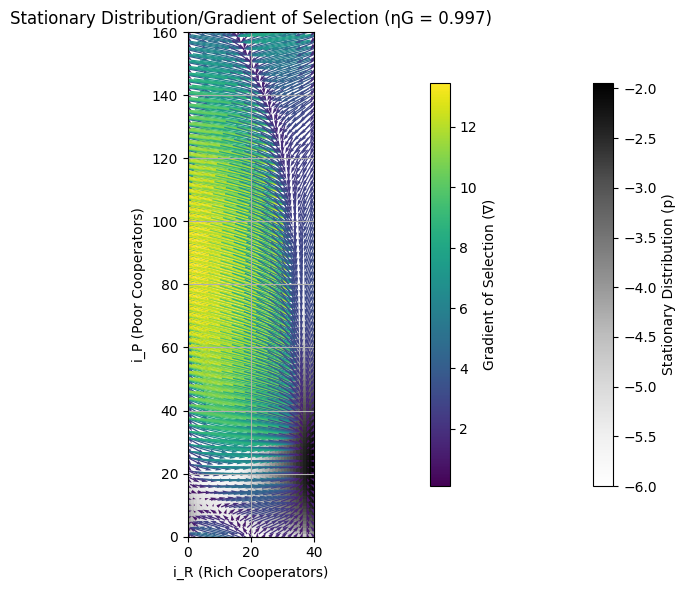

In [7]:
print("U (Gradient in i_R direction):\n", U)
print("V (Gradient in i_P direction):\n", V)

plot_gradient_of_selection(X, Y, U, V, stationary_distribution, eta_G)

In [8]:
game_3 = ClimateThresholdPublicGoodsGame(
    population_size=120,
    rich_fraction=rich_fraction,
    endowment_rich=endowment_rich,
    endowment_poor=endowment_poor,
    group_size=6,
    threshold=threshold,
    risk=0,
    contribution_factor=contribution_factor,
    homophily=0,
    beta=beta,
    mu=mu
)
eta_G = game_3.compute_eta_G()
print(eta_G)

self.average_endowment 1.0
Mcb 0.30000000000000004
0.2929357082913787


In [ ]:
# Range of risk values
risks = np.linspace(0, 1, 6)

# Compute group achievement for each scenario
eta_no_inequality = []
eta_with_inequality_h0 = []
eta_with_inequality_h1 = []

# Case 1: No inequality
endowment_rich = 1
endowment_poor = 1
homophily = 0

print("Case 1")
for r in risks:
    print(f"Risk: {r}")
    game_1 = ClimateThresholdPublicGoodsGame(
        population_size=population_size,
        rich_fraction=rich_fraction,
        endowment_rich=endowment_rich,
        endowment_poor=endowment_poor,
        group_size=group_size,
        threshold=threshold,
        risk=r,
        contribution_factor=contribution_factor,
        homophily=homophily,
        beta=beta,
        mu=mu
    )
    
    eta_G = game_1.compute_eta_G()
    print(eta_G)
    eta_no_inequality.append(eta_G)

print(eta_no_inequality)

# Case 2: With inequality, homophily = 0
endowment_rich = 2.5
endowment_poor = 0.625
homophily = 0

print("Case 2")
for r in risks:
    print(f"Risk: {r}")
    game_2 = ClimateThresholdPublicGoodsGame(
        population_size=population_size,
        rich_fraction=rich_fraction,
        endowment_rich=endowment_rich,
        endowment_poor=endowment_poor,
        group_size=group_size,
        threshold=threshold,
        risk=r,
        contribution_factor=contribution_factor,
        homophily=homophily,
        beta=beta,
        mu=mu
    )

    eta_G = game_2.compute_eta_G()
    print(eta_G)
    eta_with_inequality_h0.append(eta_G)

print(eta_with_inequality_h0)

# Case 3: With inequality, homophily = 1
homophily = 1

print("Case 3")
for r in risks:
    print(f"Risk: {r}")
    game_3 = ClimateThresholdPublicGoodsGame(
        population_size=population_size,
        rich_fraction=rich_fraction,
        endowment_rich=endowment_rich,
        endowment_poor=endowment_poor,
        group_size=group_size,
        threshold=threshold,
        risk=r,
        contribution_factor=contribution_factor,
        homophily=homophily,
        beta=beta,
        mu=mu
    )

    eta_G = game_3.compute_eta_G()
    print(eta_G)
    eta_with_inequality_h1.append(eta_G)

print(eta_with_inequality_h1)

Case 1
Risk: 0.0
self.average_endowment 1.0
Mcb 0.30000000000000004
0.7229939667624633
Risk: 0.2
self.average_endowment 1.0
Mcb 0.30000000000000004


In [ ]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(risks, eta_no_inequality, label="Without inequality", color="gray")
plt.plot(risks, eta_with_inequality_h0, label="With inequality & h=0", color="blue")
plt.plot(risks, eta_with_inequality_h1, label="With inequality & h=1", color="red")
plt.xlabel("Risk (r)")
plt.ylabel("Group Achievement (ηG)")
plt.title("Average Group Achievement vs. Risk")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()